# GENAI OPEN ENDED ASSIGNMENT

## Install Dependencies and Bring in Data

In [3]:
%pip install tensorflow  pandas matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [19]:
df = pd.read_csv(os.path.join("jigsaw-toxic-comment-classification-challenge","train.csv" , "train.csv"))

In [20]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [79]:
df.iloc[10023]

id                                                1a8bb213e3c7217d
comment_text     you are a twat \n\nI am an avid World of Warcr...
toxic                                                            1
severe_toxic                                                     0
obscene                                                          1
threat                                                           0
insult                                                           1
identity_hate                                                    0
Name: 10023, dtype: object

##  Preprocess

In [21]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      1.4.0
aniso8601                    9.0.1
anyio                        3.7.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
astroid                      2.15.5
asttokens                    2.2.1
astunparse                   1.6.3
async-lru                    2.0.2
attrs                        23.1.0
Babel                        2.12.1
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
blinker                      1.6.2
cachetools                   5.3.1
certifi                      2023.5.7
cffi                         1.15.1
charset-normalizer           3.1.0
click                        8.1.3
colorama                     0.4.6
comm                         0.1.3
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.6.7
d


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
from tensorflow.keras.layers import TextVectorization

In [23]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [24]:
MAX_FEATURES = 200000 # number of words in the vocab

In [25]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [26]:
vectorizer.adapt(X.values)

In [27]:
vectorized_text = vectorizer(X.values)

In [28]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [29]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

##  Create Sequential Model and Training

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [31]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [32]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [34]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 5725s 818ms/step - loss: 0.0624 - val_loss: 0.0457


In [35]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

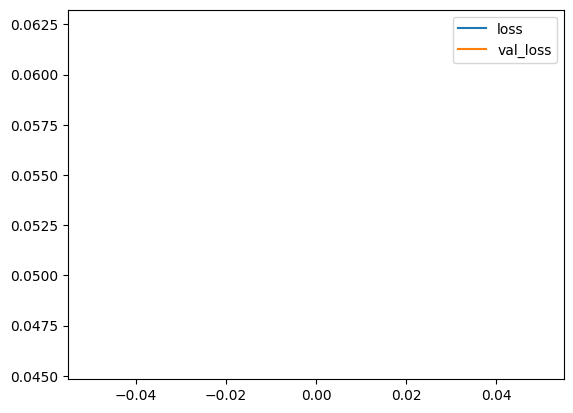

In [36]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

##  Make Predictions

In [39]:
input_text = vectorizer('You freaking suck! I am going to hit you.')
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 7158,  397, ...,    0,    0,    0], dtype=int64)>

In [40]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [41]:
batch = test.as_numpy_iterator().next()

In [43]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [46]:
(model.predict(batch_X)>0.5).astype(int)

1/1 [==============================] - 0s 135ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [47]:
res = model.predict(np.expand_dims(input_text , 0))

1/1 [==============================] - 0s 122ms/step


In [48]:
res.shape

(1, 6)

##  Evaluate Model

In [49]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [50]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [51]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 132ms/step


In [52]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8263371586799622, Recall:0.678998589515686, Accuracy:0.48445335030555725
